#Accelerated Random Search

[Original Paper](https://www.semanticscholar.org/paper/On-Accelerated-Random-Search-Appel-LaBarre/401a25fd01a1e49731ea1d715e0816d7641dbbbc)

Accelerated Random Search is an optimization method which is applicable in every (continuous) case that normal "Pure Random Search" is, while being executable in useable time and trivial to implement.

ARS also specifically specializes in dealing with functions which have near constant or even vanishing gradients due to its tendency to increase the sample radius as often as possible. Whereas other methods such as gradient descent waste time marching in this regions which is espeiscally innefficient when the cost of computing the value is at each point is high, such as when evaluating the fit of a neural network over a large data set.

ARS is suffers when it is approaching a minimum in a region with a high curvature as its chance of finding an improvement is best when the region it is searching is planar. Due to its expanding radius nature, when in such positions needless time is wasted just like gradient descent in the case mentioned above.


### Quadratic Accelerated Random Search (QARS)
A proposed solution to this issue is QARS or Quadratic Accelerated Random Search. Where all the improvement samples are recorded, and when enough are found they are used to approximate a neighborhood of the function being optimized with a paraboloid. When such paraboloid is found, its vertex is used as the next sample point.

### Immediate Applications to Data Science
Use as a function to find fits for data with a lot of outliers, by using an L1 norm.

### Possible Applications to Neural Networks
Neural Networks suffer from a vanishing gradient problem, the precise problem which ARS seeks to fix. However, Neural Networks have large dimension which ARS does not deal well with.



In [ ]:
import numpy as np

In [ ]:
#The following are helper methods for ARS, details on how they are used are found in ARS implementation


#if the best sample so far is on the border of the domain
#there is a chance that the newly chosen sample 
def clip_sample(L,U,sample):
  return np.minimum( U, np.maximum( L, (sample) ) )

#Function used for generating a new sample in a radius around the previous best sample
#N denotes the shrinking factor, when N is 1 it is the entire space, as N increases the possible domain shrinks by half
#The shrinking is also based on the dimension of the sample point, so in 3 dimensions each dimension is shrunk by the cube root of two, so that the volume is divided by half
def new_sample(L, U, scale, sample, n):
  return  clip_sample(L,U,sample + (np.random.rand(sample.size)-0.5)*scale*(2.0**(-n/sample.size) ))

In [ ]:
#an simple pure random search
#given a rectangular bounds and a function to optimize
#PRS randomly samples the domain space to find the global minimum
def PRS( domain, f, stop, every = -1):
  center = np.average( domain.reshape(-1,2), axis = 1)
  L,U = np.split( domain.reshape(-1,2), 2, axis = 1 )
  L = np.reshape(L,(-1))
  U = np.reshape(U,(-1))
  scale = (U - L)

  sample = new_sample(L,U,scale,center,1)

  best_eval = f(sample.reshape(domain.shape[:-1]))
  counter = 0
  while counter < stop:
    
    n_sample = new_sample(L,U,scale,center,1)
    n_eval = f(n_sample.reshape(domain.shape[:-1]) )
    
    if(n_eval < best_eval):
      sample = n_sample
      best_eval = n_eval
    counter = counter + 1
    if(every != - 1 and counter % every == 0):
      print( counter/every, sample,best_eval )
  return sample.reshape(domain.shape[:-1]),best_eval

In [ ]:
#an simple pure random search
#given a rectangular bounds and a function to optimize
#ARS smartly samples the space to find a local mininum
def ARS( domain, f, stop, every = -1):

  center = np.average( domain.reshape(-1,2), axis = 1)
  L,U = np.split( domain.reshape(-1,2), 2, axis = 1 )
  L = np.reshape(L,(-1))
  U = np.reshape(U,(-1))
  #use the bounds to create weights to be used to generate new points down the line
  scale = (U - L)

  #pick an initial point
  sample = new_sample(L,U,scale,center,1)

  #N specifies the size of the region being searched (around the last best sample), a larger N means a smaller region
  n = 0
  #currently our best sample is using the only point we have
  best_eval = f(sample.reshape(domain.shape[:-1]))
  counter = 0

  #we stop when our search radius gets really really low (remember radius decreases as N increases)
  while n < stop:

    #find a new sample centered around our current best sample
    n_sample = new_sample(L,U,scale,sample,n)
    #evaluate it
    n_eval = f(n_sample.reshape(domain.shape[:-1]) )
    #We premptively shrink the domain for the next pick
    #If this new sample is not an improvement, shrinking the search radius
    #increases our chance of finding an improvement with the next sample
    n = n + 1
    
    
    if(n_eval < best_eval):
      #If we do find improvement, we want to skip as much space as possible
      #(not crawl along like gradient descent)
      #in the domain so we reset our search to the entire space and shrink
      #if no subsequent improvements can be found
      n = 0

      #update the best evaluation and sample
      sample = n_sample
      best_eval = n_eval

    counter = counter + 1
    #log
    if(every != - 1 and counter % every == 0):
      print( counter/every,best_eval )
  return sample.reshape(domain.shape[:-1]),best_eval

#Quadratic Accelerated Random Search

ARS wastes sample and time in regions with high curvature. By approximating this region with a n-dimensional paraboloid, we can hope to arrive near the minimum of this region by sampling the vertex of this approximation

Before scoping out to the full domain, we first attempt a "skip" by using such a parabaloid. The implementation is quite detailed, as it has to deal with 2 degree polynomials of arbitrary dimension.

Spoilers: This section may be glossed over. As it did not perform as well as hoped

In [ ]:
#Function to generate the template for coeffecients to be multiplied in the matrix
def QUAD(n):
  return [
    [ int( (2*k+0.25)**0.5 - 0.5 ) , int(k - int( (2*k+0.25)**0.5 - 0.5 )*(int( (2*k+0.25)**0.5 - 0.5 )+1)*0.5) ] for k in range(0, int(n*(n+1)/2) )
  ] + [ [k,-1] for k in range(0,n) ] + [[-1,-1]]
#Function to use the template to create the rows of the matrix to be solved
def QUAD_ROWS(x,quad):
  return [
    [ (xi[index[0]] if index[0] != -1 else 1  )*(xi[index[1]] if index[1] != -1 else 1  ) for index in quad  ] for xi in x
  ]
#Solving the equation of the parabaloid which fits the last few points
def QUAD_FIT(x,y):
  return np.linalg.inv(x)@y

#Use the new fitted parabaloid equation in order to determine coordinates where the gradient is zero and where a potential local minimum (or maximum) is located
def GRAD_ZERO(x,quad,n):
  return [
    (sum([ x[i] if (quad[i][0] == k) != (quad[i][1] == k) else 0  for i in range(0,len(quad) ) ]))/( -2*sum([ x[i] if (quad[i][0] == k) and (quad[i][1] == k) else 0  for i in range(0,len(quad) ) ]) ) for k in range(0,n)
  ]

#Quadratic Accelerated Random Search
def QRS( domain, f, stop, every = -1, show_use = True):
  center = np.average( domain.reshape(-1,2), axis = 1)
  #precomputation for generating the matrix rows
  Q = QUAD(center.size)
  L,U = np.split( domain.reshape(-1,2), 2, axis = 1 )
  L = np.reshape(L,(-1))
  U = np.reshape(U,(-1))
  scale = (U - L)

  
  n_sample = new_sample(L,U,scale,center,0)
  n_eval = f(n_sample.reshape(domain.shape[:-1]) )
  
  n = 0
  #we now want to keep track of multiple samples in order to compute
  #the parabaloid approximation
  best_samples = [n_sample]
  best_evals = [n_eval]

  counter = 0
  works = 0
  while n < stop:

    #dummy debug variable used to count the number of parabaloid approximations
    #which end up finding improvements
    #spoilers: its low
    thing = False
    
    #Apply the parabaloid method if new data is available
    #need n = 0, since we only want to do this if the best_samples list updated
    if( n == 0 and len(best_samples) == len(Q)  ):
      
      #sometimes the data ends up being randomly picked in such a way where the
      #matrix is not invertible, or atleast not with computer precision
      #espeiscally as samples tend to be close to eachother near the end stages,
      #so we need a try catch block
      try:
        #compute the rows of the matrix to solve
        rows = np.array(QUAD_ROWS( best_samples  , Q))
        
        #compute the coefficients for the parabolid
        fit = QUAD_FIT( rows, np.array(best_evals) )
        
        #use the coefficients to find when the gradient of the paraboloid is zero
        #hopefully giving an approximation of where a local minimum might be in
        #the actual function
        n_sample = clip_sample(L,U,GRAD_ZERO(fit,Q,center.size))
        
        thing = True

    #if the try catch fails, or no new information is given:
    #the sample will be picked as it is normally    
      except:
        n_sample = new_sample(L,U,scale,best_samples[-1],n)
    else:  
      n_sample = new_sample(L,U,scale,best_samples[-1],n)
    
    n_eval = f(n_sample.reshape(domain.shape[:-1]) )
    n = n + 1
    
    #same logic as ARS but we push and pop the best sample queue
    if(n_eval < best_evals[-1]):
      n = 0


      best_samples.append( n_sample )
      best_evals.append( n_eval )
      if(thing):
        works = works + 1
      if(len(best_samples) > len(Q) ):
        best_samples.pop(0)
        best_evals.pop(0)


    counter = counter + 1
    if(every != - 1 and counter % every == 0):
      print( counter/every, best_samples[-1],best_evals[-1] )
  if(show_use):
    print(works)
  return best_samples[-1].reshape(domain.shape[:-1]),best_evals[-1]

# PRS, ARS, QARS TEST 1:
## Finding the inverse of a matrix

Here we find that PRS did manage to get close, however it required a million samples and is still quite noisy.

ARS and QARS performed equally well, particulalry since they did the same thing. QARS prints out how many times the paraboloid found an improvement, and in this case it was zero. So the QARS algorithm did not help in this case.

In [ ]:
def inverse(x):
  out = np.array( [ [2,3],[2,2] ] ) @ x - np.eye(2)
  return out.reshape(-1) @ out.reshape(-1)

domain = [
  [ [-2,2],[-2,2]  ],
  [ [-2,2],[-2,2]  ]
]


print("\n\nRunning Pure Random Search:\n")

m,err = PRS( np.array(  domain  ) , inverse , 1_000_000 )
print()
print("\nPure Random Search Final Matrix:\n")
print( m )
print("\nPure Random Search Final Error:\n")
print( err)
print("\nPure Random Search Final Multiplication:\n")
print( np.array( [ [2,3],[2,2] ] ) @ m)


print("\n\nRunning Accelerated Random Search:\n")
m,err = ARS( np.array(  domain  ) , inverse , 150 )
print()
print("\nAccelerated Random Search Final Matrix:\n")
print( m )
print("\nAccelerated Random Search Final Error:\n")
print( err)
print("\nAccelerated Random Search Final Multiplication:\n")
print( np.array( [ [2,3],[2,2] ] ) @ m)

print("\n\nRunning Quadratic Accelerated Random Search:\n")
m,err = QRS( np.array(  domain  ) , inverse , 150 )
print()
print("\nQuadratic Accelerated Random Search Final Matrix:\n")
print( m )
print("\nQuadratic Accelerated Random Search Final Error:\n")
print( err)
print("\nQuadratic Accelerated Random Search Final Multiplication:\n")
print( np.array( [ [2,3],[2,2] ] ) @ m)



Running Pure Random Search:



Pure Random Search Final Matrix:

[[-0.9966002   1.39218249]
 [ 1.0001051  -0.92123818]]

Pure Random Search Final Error:

0.0039031329468887264

Pure Random Search Final Multiplication:

[[1.0071149  0.02065042]
 [0.0070098  0.94188861]]


Running Accelerated Random Search:



Accelerated Random Search Final Matrix:

[[-1.   1.5]
 [ 1.  -1. ]]

Accelerated Random Search Final Error:

5.155324389769471e-21

Accelerated Random Search Final Multiplication:

[[ 1.00000000e+00  2.29083419e-11]
 [-3.79549725e-11  1.00000000e+00]]


Running Quadratic Accelerated Random Search:

0


Quadratic Accelerated Random Search Final Matrix:

[[-1.   1.5]
 [ 1.  -1. ]]

Quadratic Accelerated Random Search Final Error:

1.0714774358263289e-20

Quadratic Accelerated Random Search Final Multiplication:

[[ 1.00000000e+00 -2.74664735e-11]
 [-8.76312356e-11  1.00000000e+00]]


# PRS, ARS, QARS TEST 2:
## Finding the mininum of a paraboloid

After the abysmal failure of QARS in the last test, we now test how QARS performs in the ideal case: finding the minimum of a paraboloid.

Here we find, ARS outperform QARS again, though in more verbose tests QARS arrives close to the minimum in just a few steps whereas as ARS still needs much more to get closer. One would expect that QARS is able to find the minimum immediatley once enough sample points are picked. But this is not the case, usually outputing that the paraboloid found an improvement 3-6 times. It should be ONE! The approximation SHOULD be the function itself. Likely it is an issue dealing with computer error, QARS does get close but the constant used of matrix inversion makes the approach noisier.

In [ ]:
def q(x):
  return 5*(x[0]-2)**4 + 2*(x[1]-4)**2 + 3

domain = [
  [-1000,1000],[-1000,1000]
]


print("\n\nRunning Pure Random Search:\n")

m,err = PRS( np.array(  domain  ) , q , 1_000_000 )
print()
print("\nPure Random Search Final Matrix:\n")
print( m )
print("\nPure Random Search Final Error:\n")
print( err)


print("\n\nRunning Accelerated Random Search:\n")
m,err = ARS( np.array(  domain  ) , q , 150 )
print()
print("\nAccelerated Random Search Final Matrix:\n")
print( m )
print("\nAccelerated Random Search Final Error:\n")
print( err)

print("\n\nRunning Quadratic Accelerated Random Search:\n")
m,err = QRS( np.array(  domain  ) , q , 150 )
print()
print("\nQuadratic Accelerated Random Search Final Matrix:\n")
print( m )
print("\nQuadratic Accelerated Random Search Final Error:\n")
print( err)



Running Pure Random Search:



Pure Random Search Final Matrix:

[1.74882286 3.98150687]

Pure Random Search Final Error:

3.020585702509094


Running Accelerated Random Search:



Accelerated Random Search Final Matrix:

[1.99857969 4.00000002]

Accelerated Random Search Final Error:

3.0000000000203477


Running Quadratic Accelerated Random Search:

4


Quadratic Accelerated Random Search Final Matrix:

[2.00050217 4.        ]

Quadratic Accelerated Random Search Final Error:

3.000000000000318


Setup for one of the most immediate uses of ARS:
Linear Regression using L1 norm

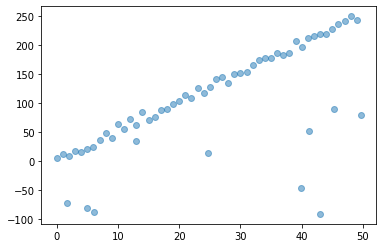

In [ ]:
import matplotlib.pyplot as plt

#Compute the norm with an arbitrary power (so L2 norm, L1 norm, and even L 0.5 norm)
def fit_LA(x,y,A):
  dummy = x.copy()
  def f(linpar):
    #predict from x
    np.multiply(x,linpar[0],out=dummy)
    np.add(dummy,linpar[1],out=dummy)
    np.subtract(dummy,y,out=dummy)
    np.abs(dummy,out=dummy)
    np.power(dummy,A,out=dummy)
    return np.sum(dummy)**(1.0/A)
  return f


a = 5
b = 5
r = 10

N = 50
xr = np.arange(N)*1.0
yr = a*xr + (np.random.rand(N)-0.5)*2*r + b

x_outlier = np.random.rand(10)*50.0
y_outlier = (np.random.rand(10)-0.5)*2*100.0

x = np.concatenate( (xr,x_outlier) )
y = np.concatenate( (yr,y_outlier) )

plt.scatter(x, y, alpha=0.5)
plt.show()

#(Q)ARS Application 1:
## Regression with non-differentiable norms

Theory tells us that an L1 norm is less sensitive to outliers in data. But an L1 norm involves an absolute value, which does not play well with calculus or linear algebra and are thus harder to compute and the more algebra friendly L2 norm is used when possible. ARS presents a possible use case in this regard, to be able to find an L1 fit to data.

This section also explores the idea of an L0.5 fit and also discovers why that it is a bad idea.

QARS is used in this section, since it does not really seem to hurt. In the verbose logs QARS demonstrated that the parabaloid approximations found an improvement roughly 3-5 times per an instance, so the method does appear to be working in some limited capacity. The logs were ommited in the Notebook copy of the project as the test was run 1000 times.

The code above is used to generate a new set of points to fit. The graph represents the data: fuzzy uniform noise around a line ( Y = 5x + 5) with a few completely random outliers.

The data supported the theory: The L2 norm gave skewed results compared to the L1 and L0.5 norms. How,ever the L0.5 norm was much more skewed than the L1 norm. In all cases the intercept was incredibly noisly, but the same trend applies

hi
% completed: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


% completed: 2.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


% completed: 5.0
% completed: 7.5
% completed: 10.0
% completed: 12.5
% completed: 15.0
% completed: 17.5
% completed: 20.0
% completed: 22.5
% completed: 25.0
% completed: 27.5
% completed: 30.0
% completed: 32.5
% completed: 35.0
% completed: 37.5
% completed: 40.0
% completed: 42.5
% completed: 45.0
% completed: 47.5
% completed: 50.0
% completed: 52.5
% completed: 55.0
% completed: 57.5
% completed: 60.0
% completed: 62.5
% completed: 65.0
% completed: 67.5
% completed: 70.0
% completed: 72.5
% completed: 75.0
% completed: 77.5
% completed: 80.0
% completed: 82.5
% completed: 85.0
% completed: 87.5
% completed: 90.0
% completed: 92.5
% completed: 95.0
% completed: 97.5


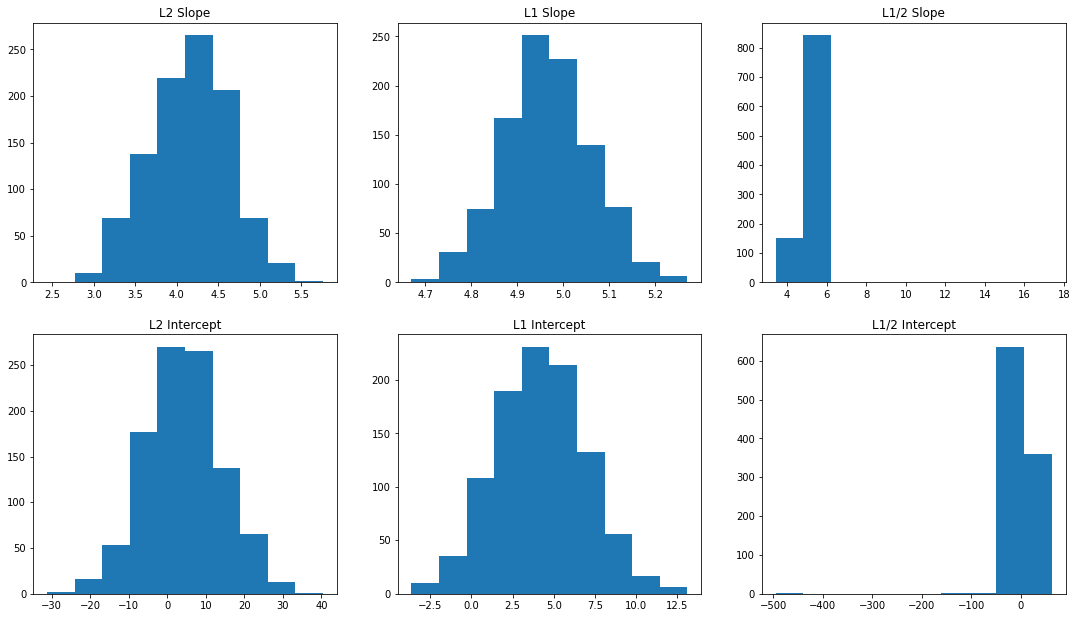

In [ ]:
domain = [
    [-1000,1000],[-1000,1000]
  ]

results = []
print("hi")
for i in range(0,1000):

  xr = np.arange(N)*1.0
  yr = a*xr + (np.random.rand(N)-0.5)*2*r + b

  x_outlier = np.random.rand(10)*50.0
  y_outlier = (np.random.rand(10)-0.5)*2*100.0

  x = np.concatenate( (xr,x_outlier) )
  y = np.concatenate( (yr,y_outlier) )

  result_vec = []

  #print("L2 NORM: ")
  m,err = QRS( np.array(  domain  ) , fit_LA(x,y,2) , 150, show_use = False )
  #print()
  #print( m )
  #print( err)
  result_vec.append(m)

  #print("L1 NORM: ")
  m,err = QRS( np.array(  domain  ) , fit_LA(x,y,1) , 150, show_use = False )
  #print()
  #print( m )
  #print( err)
  result_vec.append(m)
      
  #print("L1/2 NORM: ")
  m,err = QRS( np.array(  domain  ) , fit_LA(x,y,0.5) , 150, show_use = False )
  #print()
  #print( m )
  #print( err)
  result_vec.append(m)

  results.append(result_vec)

  if(i % 25 == 0):
    print("% completed:" ,100.0*i/1000)

results_np = np.array(results)

L2,L1,L1_2 = zip(*results_np)

M2,B2 = zip(*L2)

M1,B1 = zip(*L1)

M1_2,B1_2 = zip(*L1_2)

fig,axs = plt.subplots(nrows=2,ncols=3)

fig.set_size_inches(18.5, 10.5)

axs[0,0].set_title("L2 Slope")
axs[0,0].hist( M2 )

axs[0,1].set_title("L1 Slope")
axs[0,1].hist( M1 )

axs[0,2].set_title("L1/2 Slope")
axs[0,2].hist( M1_2 )

axs[1,0].set_title("L2 Intercept")
axs[1,0].hist( B2 )

axs[1,1].set_title("L1 Intercept")
axs[1,1].hist( B1 )

axs[1,2].set_title("L1/2 Intercept")
axs[1,2].hist( B1_2 )

plt.show()

#Manually writing an ARS Optimizer for Keras
To be honest, Keras is still quite confusing to me. For writing the optimizer to use ARS on neural networks I decided to reduce it to the already solved numpy array problem I developed ARS in. This required writing an efficient map which turned numpy arrays into weights which can be fed into Keras.

To this I crated a helper function: `create_packer`

`create-packer` takes the weights from an already compiled keras model to generate a function which can take a numpy array, turn it into a buffer, and make a list of numpy arrays which view (not copy) the original data in a format which can be assigned to the Keras Network.

`compile_ARS_trainer` simply takes a model and a packer and outputs a function that ARS can use to train the network.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import datetime

#We need a method to turn a flat numpy array into the form that keras can use
def create_packer( init_data ):
  shapes = [array.shape for array in init_data]
  sizes = np.array( [array.size for array in init_data] )
    
  offsets = np.cumsum( sizes )-sizes# - sizes[0]

  def outputter(data):
    buffer = data.data
    return [ np.frombuffer(buffer, dtype=float , count = sizes[i], offset = offsets[i]*8 ).reshape(shapes[i]) for i in range(0, len(shapes) ) ]
  return np.sum(sizes),outputter

def compile_ARS_trainer(model,packer):
  def train_ARS(vec):
    pack = packer(vec)
    model.set_weights(pack)
    return model.test_on_batch(X,Y)
  return train_ARS

# prepare data set
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([[0], [1], [1], [0]])
            


#ARS vs Adam

Here we see the surprising result of ARS generating less loss than the default "Adam" optimization in Keras, in the problem of representing an XOR function.

It is unknown from just this data whether ARS is a good scheme for Neural Networks in general, or we just got luck with this example.

There was a similar test run on the scilearn iris dataset. ARS tried to compete but failed miserably. The neural network had over 600 weights, due to the surprising sucess of ARS in this test it leads me to believe the large dimension was the main factor for ARS' poor performace, because after all ARS was designed to work in the vanishing gradient problem. It thus warrants further investigation as to what cases does ARS work for training neural networks, and can alterations be made to help it converge in the case of high dimension.

(The iris dataset was ommited to the extreme amount of time it took for ARS to converge, it would not work in a notebook)

Originally this project did not even anticipate that there would be a case where ARS outperformed traditional NN optimization. The scope was intended to be limited to applying L1 loss functions, under the assumption that L1 could not be operated by neural networks (this idea was completely dismissed once the documentation for Keras loss functions was read).

At the time of this writing the graphs are still being computed, so comments can be made about their appearace. But if they match up with the tests done on my local machine, pay attention to the scale on the x-axis for ARS, at first glance it looks like ARS is far worse than Adam, but it is in fact much less lossy.

In [ ]:
def run_normal():
  # create model   
  model = Sequential()
      
  # Adding the input layer and the first hidden layer
  model.add(Dense(8, activation = 'relu', input_dim = 2))
  # Adding the second hidden layer
  model.add(Dense(4, activation = 'relu'))
  # Adding the output layer
  model.add(Dense(1, activation = 'sigmoid'))

      
  # compile model   
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
      
  # fit the model
  start = datetime.datetime.now()
  model.fit(X, Y, batch_size = 1, epochs = 750, verbose = 0)
  end = datetime.datetime.now()
    
  loss,acc = model.evaluate(X, Y, verbose = 0)
  # evaluate the model
  return loss,acc,(end-start).microseconds


def run_ARS():
  # create model   
  model = Sequential()
      
  # Adding the input layer and the first hidden layer
  model.add(Dense(8, activation = 'relu', input_dim = 2))
  # Adding the second hidden layer
  model.add(Dense(4, activation = 'relu'))
  # Adding the output layer
  model.add(Dense(1, activation = 'sigmoid'))

      
  # compile model   
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

  


  size_of_data,packer = create_packer( model.get_weights() )

  domain = np.array( [ [-10,10] for i in range(0,size_of_data)  ] )

  

  start = datetime.datetime.now()
  m,err = ARS( domain , compile_ARS_trainer(model,packer) , 1500 )
  end = datetime.datetime.now()
    
  loss,acc = model.evaluate(X, Y, verbose = 0)
  # evaluate the model
  return loss,acc,(end-start).microseconds



losses_normal = []
times_normal = []

losses_ars = []
times_ars = []
for i in range(0,500):
  norm = run_normal()
  ars = run_ARS()
  losses_normal.append(norm[0])
  times_normal.append(norm[2])
  losses_ars.append(ars[0])
  times_ars.append(ars[2])
  if(i % 25 == 0):
    print("% completed:" ,100.0*i/500)



% completed: 0.0
% completed: 5.0
% completed: 10.0
% completed: 15.0
% completed: 20.0
% completed: 25.0
% completed: 30.0
% completed: 35.0
% completed: 40.0
% completed: 45.0
% completed: 50.0
% completed: 55.0
% completed: 60.0
% completed: 65.0
% completed: 70.0
% completed: 75.0
% completed: 80.0
% completed: 85.0
% completed: 90.0
% completed: 95.0


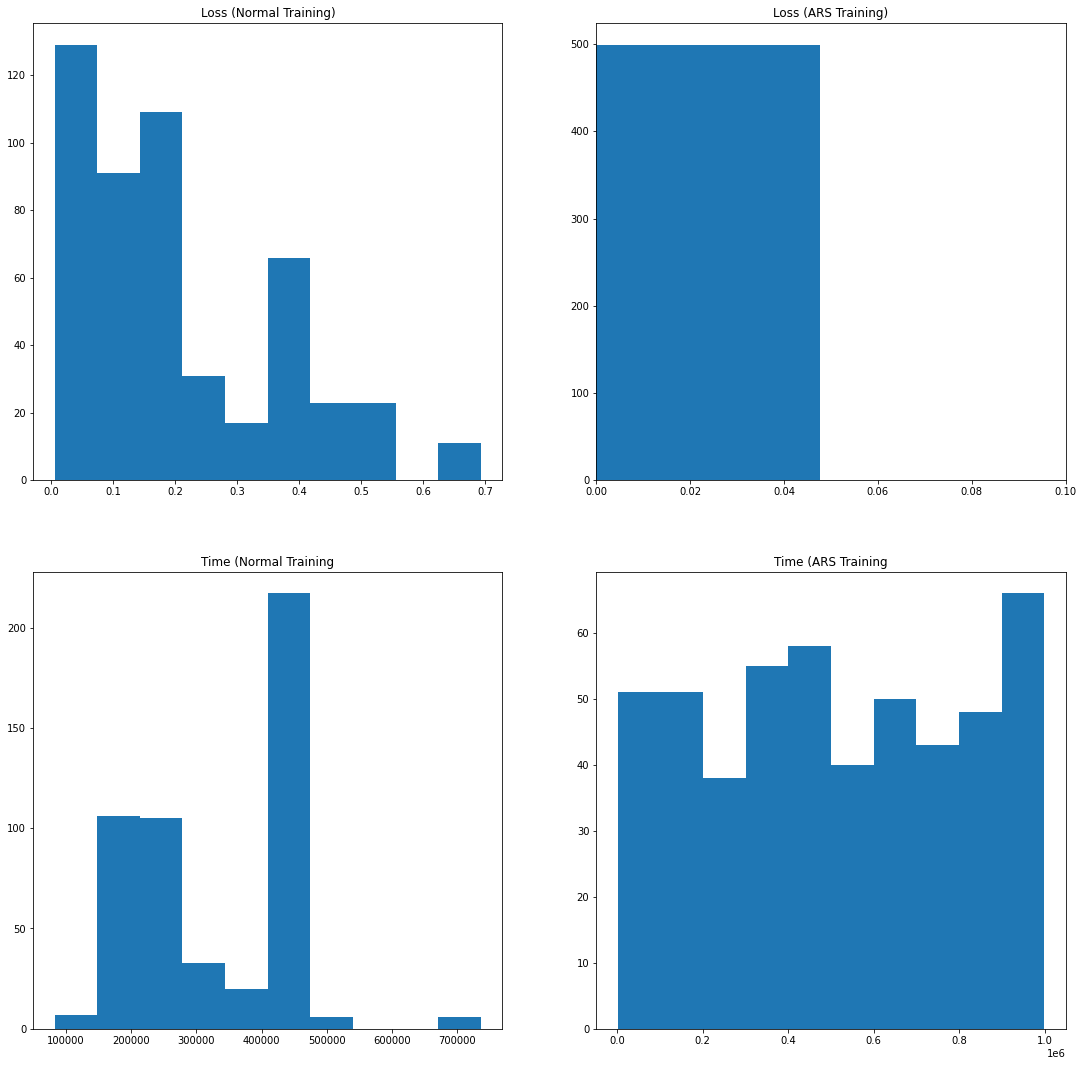

In [ ]:
fig,axs = plt.subplots(nrows=2,ncols=2)

fig.set_size_inches(18.5, 18.5)

axs[0,0].set_title("Loss (Normal Training)")
axs[0,0].hist( losses_normal )

axs[0,1].set_title("Loss (ARS Training)")
axs[0,1].hist( losses_ars )
axs[0,1].set_xlim([0.0,0.1])

axs[1,0].set_title("Time (Normal Training")
axs[1,0].hist( times_normal )

axs[1,1].set_title("Time (ARS Training")
axs[1,1].hist( times_ars )

plt.show()